# TME 10 : méthodes discriminantes

Le but de ce TME est de comparer les approches en modélisation maximum de vraisemblance et maximum a posteriori au niveau de la modélisation même du problème dans le cas de la classification. 

Nous notons  les observations $\mathbf x_i \in \mathbb R^d$ et les étiquettes binaires associées $y_{i} \in \mathcal Y = \{0, 1\}$.
Nous faisons l'hypothèse que les couples $(\mathbf x_i, y_{i})$ sont tirés de manière i.i.d. et suivent une loi inconnue $P(X,Y)$. 

***Résumé du max de vraisemblance:***<BR>
1. Choix d'une modélisation $\Theta$ pour les $\mathbf x_i$ (par exemple une gaussienne multivariée ou une modélisation dimension par dimension selon une loi choisie en accord avec les experts du domaine).
1. Formalisation de la vraisemblance pour un échantillon:
$p(\mathbf x_i | \Theta)$
1. Pour chaque classe $y$ (0 ou 1 dans le cas présent), optimisation de 
    $$\Theta_y^\star = \arg \max_{\Theta} \prod_{i \in y} p(\mathbf x_i | \Theta)$$
1. Critère de décision pour un nouvel échantillon $\mathbf x_n$:
    $$\hat y_n = \arg \max_c p(\mathbf x_n | \Theta_y) $$

La méthode est simple et efficace mais ne compare jamais les échantillons des différentes classes pour prendre une décision.

***Idée des approches discriminantes:***<BR>
1. Choix d'un modèle pour $p(y_i | \mathbf x_i)$. Le modèle le plus connu est la régression logistique qui, comme le nom ne l'indique pas est un modèle de classification. C'est ce modèle que nous allons étudier:
    $$p(y_i=1 | \mathbf x_i) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))},\qquad \mbox{Paramètres : } \mathbf w, b $$
1. Dans le cas à deux classes uniquement; après avoir remarqué que nous avons choisi un codage des classes de type Bernoulli... Utilisation de l'astuce de Bernoulli pour calculer la vraisemblance d'un échantillon:
$$ p(y_i | \mathbf x_i) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i} $$
1. Max de vraisemblance sur ***sur l'ensemble des données***:
    $$\mathbf w^\star, b^\star = \arg \max_{\mathbf w, b} \prod_{i} p(\mathbf x_i, y_i | \mathbf w, b) = \arg \max_{\mathbf w, b} \prod_{i} p( y_i|\mathbf x_i, \mathbf w, b) p(\mathbf x_i| \mathbf w, b)$$
En faisant l'hypothèse que les $\mathbf x_i$ sont équiprobables (pas de poids sur les observations):
$$\mathbf w^\star, b^\star = \arg \max_{\mathbf w, b} \prod_{i} p( y_i|\mathbf x_i, \mathbf w, b)$$


## Chargement des librairies et des données USPS

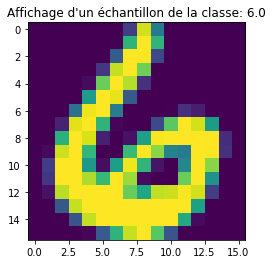

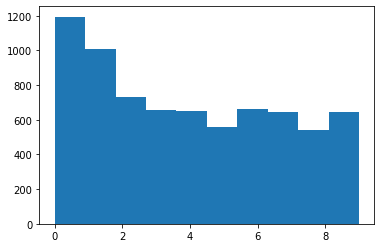

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

# étude très rapide des données:
plt.figure()
plt.hist(Y, 10) # histogramme de répartition des 10 classes
plt.show()

## Exercice 1: retour sur le max de vraisemblance

Nous retravaillons rapidement le max de vraisemblance pour obtenir un baseline. Nous allons travailler en bayesien naif sur des images binarisées:
$$ x_{ij} \in \{0,1\}, \qquad p(x_i | \Theta) = \prod_j p(x_{ij} | \Theta_j)$$

Le code est fourni, il suffit de l'exécuter:

In [2]:
# apprentissage d'un modèle de Bernoulli naif par classe
def learnBernoulli (X,Y):
    theta = [(X[Y==y].mean(0)) for y in np.unique(Y)]
    return np.array(theta)

# evaluation de la vraisemblance d'une base d'échantillon
# retourne une matrice avec les vraisemblances des échantillons pour toutes les classes
def logpobsBernoulli(X, theta):
    seuil = 1e-4
    theta = np.maximum(np.minimum(1-seuil, theta),seuil)
    logp = [[ (x*np.log(mod)+(1-x)*np.log(1-mod)).sum() for x in X] for mod in theta ]
    return np.array(logp)

Bernoulli : Taux bonne classification en apprentissage :  0.8723083253326018
Bernoulli : Taux bonne classification en test :  0.8236173393124065


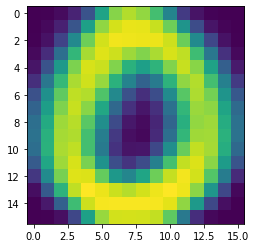

In [3]:
# binariser X (sinon la modélisation Bernoulli ne tient plus)
Xb = np.where(X >0, 1., 0.)
Xbt = np.where(Xt >0, 1., 0.)


## Max de Vraisemblance
theta = learnBernoulli ( Xb,Y )
## Evaluation de la vraisemblance des échantillons
logp  = logpobsBernoulli(Xb, theta)
logpT = logpobsBernoulli(Xbt, theta)

# calcul des y de prédiction à partir de la matrice des vraisemblances
ypred_b  = logp.argmax(0)
ypredT_b = logpT.argmax(0)

print("Bernoulli : Taux bonne classification en apprentissage : ",np.where(ypred_b != Y, 0.,1.).mean())
print("Bernoulli : Taux bonne classification en test : ",np.where(ypredT_b != Yt, 0.,1.).mean())

# resultats qualitatifs: affichage des poids du modèle de la classe 0
plt.figure()
plt.imshow(theta[0].reshape(16,16))
plt.show()

## Exercice 2: prise en compte des informations a priori et passage au MAP

La seule information dont nous disposons est la répartition des classes (cf histogramme).
1. Calcul des probabilités a priori des classes 
1. Evaluation des performances avec prise en compte de ces informations a priori
1. Afficher les images des chiffres qui changent de classe avec les prédictions avant/après

Cet exercice correspondant principalement à des compétences de séances précédentes, le code est fourni.

Bernoulli : Taux bonne classification MAP en apprentissage :  0.8720340145384721
Bernoulli : Taux bonne classification MAP en test :  0.8236173393124065


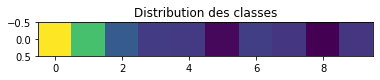

<Figure size 432x288 with 0 Axes>

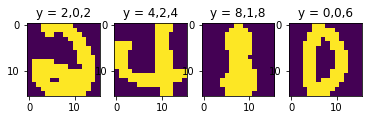

In [4]:
# CORRECTION
pAPriori = np.array([np.where(Y==i, 1, 0).sum() for i in np.unique(Y)]).reshape(10,1) / len(Y)

plt.figure()
plt.imshow(pAPriori.T, interpolation=None)
plt.title('Distribution des classes')

# pas de modification sur les paramètres optimaux
ypred  = (logp + np.log(pAPriori)).argmax(0) # utilise le dispatch numpy
ypredT = (logpT+ np.log(pAPriori)).argmax(0)

print ("Bernoulli : Taux bonne classification MAP en apprentissage : ",np.where(ypred != Y, 0.,1.).mean())
print ("Bernoulli : Taux bonne classification MAP en test : ",np.where(ypredT != Yt, 0.,1.).mean())

# recherche d'un point ayant changé de classe avec le MAP:
index = np.where(ypred != ypred_b)[0]
plt.figure()
plt.subplots(1,len(index))
for num,i in enumerate(index):
    plt.subplot(1,len(index),num+1) # subplot commence à 1 (héritage matlab)
    plt.imshow(Xb[i].reshape(16,16))
    plt.title("y = "+str(int(Y[i])) + ","+str(ypred[i])+","+str(ypred_b[i]) )
plt.show()

## Exercice 3: codage de la régression logistique

***Rappel: régression logistique = système de classification***

$$ p(y_i | \mathbf x_i) = \left( \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{y_i} \left(1- \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}\right)^{1-y_i} $$


Soit en agrégeant sur la base de données et notant: $exp = \exp( -(  \mathbf x_i  \mathbf w + b))$
$$\mathcal L_{log} = \sum_i  y_i \log(\frac{1}{1+exp}) + (1-y_i) \log(1-\frac{1}{1+exp})$$ 
$$\mathcal L_{\log}=\sum_{i=1}^N \log(1+exp) ( -y_i -1 + y_i) + \log(exp)(1-y_i)$$

Soit:
$$ \frac{\partial  }{\partial w_j} L_{\log} =\sum_{i=1}^N x_{ij}( y_i-\frac{1}{1+exp}) \in \mathbb R$$
On remarque qu'il est possible de passer à une écriture vectorielle:
$$ \nabla_{\mathbf w} L_{\log} =X^T ( Y-\frac{1}{1+\exp( -(  \mathbf X  \mathbf w + b))}) \in \mathbb R^d$$
$$ \frac{\partial  }{\partial b} L_{\log} =\sum_{i=1}^N ( y_i-\frac{1}{1+exp}) \in \mathbb R$$

Note: il est possible de manière **facultative**, comme dans le TME de la semaine dernière, de construire:
$$Xe = \left[\begin{array}{cc}
                \mathbf x_0 & 1\\
                \vdots & \vdots\\
                \mathbf x_N & 1
                \end{array}
                \right] $$
On supprime alors les $b$ pour obtenir:
$$ \nabla_{\mathbf w_e} L_{\log} =X_e^T ( Y-\frac{1}{1+\exp( -(  \mathbf X_e  \mathbf w_e))}) \in \mathbb R^{d+1}$$

### Liste des questions
1. Coder la descente de gradient classique (batch) entre deux classes <BR>
    Attention, il s'agit d'une montée de gradient pour maximiser la vraisemblance <BR>
    Proposition de critère d'arrêt: $\max_j(|w_{new,j} - w_{old,j}| ) < 10^{-3}$
1. Evaluer les performances sur la distinction entre les 2 et les 3
1. Passer au multi-classe avec le paradigme un-contre-tous
1. [OPT, à faire à la fin] passer à un algorithme de gradient stochastique

In [103]:
#1. montée de gradient
def rl_gradient_batch(X,Y, epsilon = 1e-3, niter_max=1000):
    N,d = X.shape
    w = np.zeros(d+1)
    #w = np.random.randn(d+1)
    b = np.ones((N,1))
    Xe = np.hstack((X, b))
    
    for i in range(niter_max):
        pred = 1 / (1 + np.exp(-(np.dot(Xe,w))))
        wNew= w + epsilon * np.dot(Xe.T , (Y - pred))

        if np.abs(wNew - w).max() < 1e-3:
            print("convergence atteinte en  {}  itérations".format(i))
            return w
        w = wNew
    
    print("convergence atteinte en  {}  itérations".format(i))
    return w

In [189]:
#1. montée de gradient
def rl_gradient_batch(X,Y, epsilon = 1e-3, niter_max=1000):
    N,d = X.shape
    w = np.zeros(d)
    #w = np.random.randn(d)
    b = np.ones(N)
    
    for i in range(niter_max):
        pred = 1 / (1 + np.exp(-(np.dot(X,w)+b)))
        wNew= w + epsilon *np.dot(X.T , (Y - pred)) 
        b = b + epsilon * (Y - pred)
        if np.abs(wNew - w).max() < 1e-3:
            print("convergence atteinte en  {}  itérations".format(i))
            return w,b
        w = wNew
    
    print("convergence atteinte en  {}  itérations".format(i))
    return w,b

In [190]:
# 2. cas sur les classes 2 et 3 & passage à un codage 0/1 pour Y
cl1 = 2
cl2 = 3
X_23 = X[(Y==cl1)|(Y==cl2),:]
Y_23 = np.where(Y[(Y==cl1)|(Y==cl2)] == cl1, 1., 0.)
Xt_23 = Xt[(Yt==cl1)|(Yt==cl2),:]
Yt_23 = np.where(Yt[(Yt==cl1)|(Yt==cl2)] == cl1, 1., 0.)
print("Taille des données :",X_23.shape,Y_23.shape)

# application de la montée de gradient & evaluation des performances
# attention à afficher les Ypred et les Y_23 pour vérifier qu'ils sont comparables
# vous pouvez utiliser np.round

w,b = rl_gradient_batch(X_23,Y_23)

#Xe = np.hstack((X_23, np.ones((X_23.shape[0],1))))
#sigmoid = 1 / (1 + np.exp(-(np.dot(Xe,w))))

sigmoid = 1 / (1 + np.exp(-(np.dot(X_23,w))))

pred = np.round(sigmoid)
print("Accuracy Train: {0}".format((pred == Y_23).sum().astype(float) / len(pred)))




#Xe = np.hstack((Xt_23, np.ones((Xt_23.shape[0],1))))
#sigmoid = 1 / (1 + np.exp(-(np.dot(Xe,w))))

sigmoid = 1 / (1 + np.exp(-(np.dot(Xt_23,w))))

pred = np.round(sigmoid)
print("Accuracy Test: {0}".format((pred == Yt_23).sum().astype(float) / len(pred)))




Taille des données : (1389, 256) (1389,)
convergence atteinte en  299  itérations
Accuracy Train: 0.9978401727861771
Accuracy Test: 0.9532967032967034


Sortie attendue
```
Taille des données : (1389, 256) (1389,)
convergence atteinte en  330  itérations # si vous avez fait un print dans le critère d'arret
[0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.] 
 [0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
App :  0.9992800575953924
Test :  0.9615384615384616
```

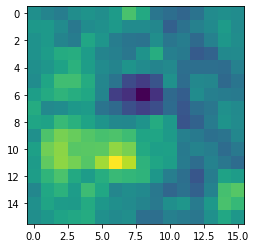

In [166]:
plt.figure()
plt.imshow(w[:-1].reshape(16,16))
plt.savefig("w23.png")
# montrer les paramètres des modèles génératifs des classes 2 et 3 pour comparer

### Passage au multiclasse

Nous allons utiliser le paradigme *un-contre-tous* mais nous allons le coder proprement dans une fonction.
Dans la fonction ```rl_multi(X,Y, epsilon = 1e-3, niter_max=1000)``` effectuer les opérations suivantes:

1. Extraire toutes les classes de Y
1. Pour chaque classe
11. Construire Ycl telle que:
$$Y_{cl} = \left\{ 
\begin{array}{cl}
1 & \mbox{ si } Y == cl     \\
0 & \mbox{ sinon (pour toutes les autres classes) }
\end{array}
\right.$$
11. Lancer un apprentissage
1. Empiler tous les $\mathbf w$ & $b$ comme suit:

$$W = \left[\begin{array}{cccc}
                \\
                \mathbf w_{cl=0} & \mathbf w_{cl=1} & \ldots & \mathbf w_{cl=9}
                \\ \\
                \end{array}
                \right] $$
$$\mathbf b = \left[\begin{array}{cccc}
                \mathbf b_{cl=0} & \mathbf b_{cl=1} & \ldots & \mathbf b_{cl=9}
                \end{array}
                \right] $$
                
On peut alors montrer que:
$$ \frac{1}{1+\exp( - \mathbf X W - \mathbf b)}  = \left[\begin{array}{cccc}
                p(Y = 1 | X = \mathbf x_1) & p(Y = 2 | X = \mathbf x_1) & \ldots & p(Y = 9 | X = \mathbf x_1)
                \\ 
                \vdots & &\ddots & \vdots\\
p(Y = 1 | X = \mathbf x_N) & p(Y = 2 | X = \mathbf x_N) & \ldots & p(Y = 9 | X = \mathbf x_N)
\\
                \end{array}
                \right] \in \mathbb R^{N\times C}$$
               Avec $N$ points et $C$ classes
1. Utiliser un ```argmax``` pour extraire le numéro de classe

In [231]:
def rl_multi(X,Y, epsilon = 1e-3, niter_max=1000):
    N,d = X.shape
    classes = np.unique(Y)
    # Initialiser les poids & lancer un modèle par classe
    # dans la boucle for, vous pouvez utiliser : Y_tmp = np.where(Y == c, 1., 0.)
    W = []
    B = []
    for c in classes:
        Y_tmp = np.where(Y == c, 1., 0.)
        w , b = rl_gradient_batch(X,Y_tmp,epsilon,niter_max)
        W.append(w)
        B.append(b)
    return np.asarray(W).T, np.asarray(B).T

In [242]:
# duree execution = 30 secondes
# n'hésitez pas à mettre un niter_max à 10 durant la phase de debug pour gagner du temps !
W,B = rl_multi(X,Y)

print(B)

C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
[[0.99788109 0.99926894 0.99832582 ... 0.99926894 0.99926894 0.99926894]
 [0.99826534 0.99926894 0.99600557 ... 0.99926894 0.99926894 0.99926894]
 [0.96757921 0.99926894 0.99833108 ... 0.99926894 0.99926894 0.99926894]
 ...
 [0.99826894 0.99926894 0.99596607 ... 0.99926894 0.99899279 0.99926894]
 [1.00526955 0.99926894 0.99840884 ... 0.99926894 0.99926894 0.99926894]
 [0.99926894 1.14966237 0.99752268 ... 0.99926892 0.94383642 0.99925691]]


In [233]:
# perf:
Y_pred  = np.argmax(1/(1+np.exp(-X@W - B)),1)
Yt_pred = np.argmax(1/(1+np.exp(-Xt@W -B[Xt.shape[0],:])),1)
# print(Yt[:20],"\n",Yt_pred[:20])
    
pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

App :  0.8843780002743108
Test :  0.8310911808669657


Performances attendues:
```
App :  0.8824578247154026
Test :  0.8166417538614849
```
Pour l'instant, on ne voit pas encore l'intérêt... Mais ça va venir!

## Exercice 4: Analyse de l'évolution de la vraisemblance 

Afin de vérifier le bon fonctionnement de l'algorithme, nous proposons de calculer la vraisemblance au cours des itérations (par exemple, toutes les 10 itérations) et de retourner le résultat pour voir comment se déroule l'apprentissage et pouvoir éventuellement ajuster la valeur de $\epsilon$.

En repartant de:
$$\mathcal L_{log} = \sum_i  y_i \log(\frac{1}{1+exp}) + (1-y_i) \log(1-\frac{1}{1+exp})$$ 
Avec : $exp = \exp( -(  \mathbf x_i  \mathbf w + b))$

Modifier la fonction de calcul de la vraisemblance pour retourner l'évolution de la vraisemblance

In [213]:
def rl_gradient_batch_L(X,Y, epsilon = 1e-3, niter_max=1000):
    N,d = X.shape
    L = [] # init vraisemblance
    # meme code que précédemment
    # même si c'est peu recommandé en GL... Faites un copier-coller pour gagner du temps
    N,d = X.shape
    w = np.zeros(d)
    #w = np.random.randn(d)
    b = np.ones(N)
    for i in range(niter_max):
        pred = 1 / (1 + np.exp(-(np.dot(X,w)+b)))
        wNew= w + epsilon * np.dot(X.T , (Y - pred))
        b = b + epsilon * (Y - pred)
        if i % 10 == 0:
            L.append((Y * np.log(pred) + (1-Y) * np.log( 1 - pred+epsilon)).sum())
        if np.abs(wNew - w).max() < 1e-3:
            print("convergence atteinte en  {}  itérations".format(i))
            return w,b,np.array(L)
        w = wNew
    
    print("convergence atteinte en  {}  itérations".format(i))
    return w,b,np.array(L)



convergence atteinte en  299  itérations
[-1090.6783919   -238.3329885   -149.52003215  -119.80099371
   -99.13186946   -84.10787628   -72.77433474   -63.47263307
   -55.32537049   -48.03068444   -41.58943229   -36.14795292
   -31.71135665   -28.06559008   -24.97582197   -22.30113576
   -19.9801069    -17.97423592   -16.23355318   -14.70743388
   -13.36047053   -12.17250528   -11.13192305   -10.22891154
    -9.45120676    -8.78339246    -8.20869921    -7.71116981
    -7.27694615    -6.89462557]


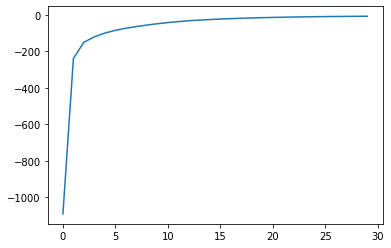

In [214]:
# cas sur les classes 2 et 3 & passage à un codage 0/1 pour Y
cl1 = 2
cl2 = 3
X_23 = X[(Y==cl1)|(Y==cl2),:]
Y_23 = np.where(Y[(Y==cl1)|(Y==cl2)] == cl1, 1., 0.)
Xt_23 = Xt[(Yt==cl1)|(Yt==cl2),:]
Yt_23 = np.where(Yt[(Yt==cl1)|(Yt==cl2)] == cl1, 1., 0.)
#print("Taille des données :",X_23.shape,Y_23.shape)

w,b,L = rl_gradient_batch_L(X_23,Y_23, epsilon = 1e-3)
print(L)

plt.figure()
plt.plot(L)

## Exercice 5: Analyse qualitative des solutions

Quels sont les pixels qui jouent un role dans la décision?

1. Pour une classe de données, je peux déjà afficher l'ampleur des poids $\mathbf w$ associés à chaque classe. Cela indique si les pixels sont pondérés positivement ou négativement.
1. Pour une image donnée, je sais que la décision est de la forme:
$$p(y_i=1 | \mathbf x_i) = \frac{1}{1 + \exp( -(  \mathbf x_i  \mathbf w + b))}$$
Ainsi, la décision est formée d'une addition de $x_{ij}\cdot w_j$: les plus fortes composante en valeur absolue sont celles qui participent le plus à la décision. <BR>
Cette approche est particulièrement intéressante pour analyser les erreurs de classification.
Afficher l'image d'un chiffre mal classé et une carte de chaleur indiquant quelles parties de l'image influencent le plus la décision: pour la classe prédite d'une part et pour la classe réelle d'autre part.

<Figure size 432x288 with 0 Axes>

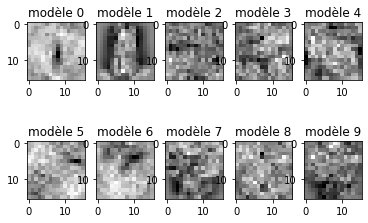

In [215]:
# affichage des poids des paramètres des 10 classes (PAS DE CODE A AJOUTER)
# prérequis: que les w soit en colonnes dans la matrice W
plt.figure()
plt.subplots(2, 5)
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.imshow(W[:,i].reshape(16,16), cmap="gray")
    plt.title("modèle "+str(i))



3


<Figure size 432x288 with 0 Axes>

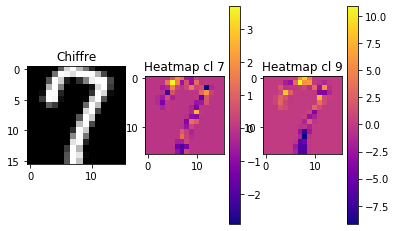

In [230]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(X[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow((X[index]*W[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow((X[index]*W[:,int(Y_pred[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Y_pred[index])))
plt.colorbar()
plt.savefig("malclasse.png")


### Exercice 5-2: limite de la représentation des chiffres

L'expérience précédente met en lumière un phénomène évident: seuls les pixels non nuls jouent un role dans la classification.
C'est très pénalisant, le fait qu'un pixel soit éteint ne peut influencer la décision que par son inaction... Mais pas forcer le système à aller dans une autre classe.

Ce problème est aisément contournable: il suffit de travailler sur $X-1$ (les valeurs de pixels étant entre $0$ et $2$). Les $-1$ qui apparaissent vont alors jouer un role dans la décision.

1. Ré-utiliser (sans modification) ```rl_multi``` sur $X-1$
1. Calculer les performances en pensant bien à faire l'inférence sur $Xt-1$
1. Afficher les contributions des pixels dans cette nouvelle configuration pour une image mal classée

Note: avec la régression logistique, les classes $Y$ doivent être dans $\mathcal Y=\{0,1\}$... Mais il n'y a pas de contrainte sur les $X$. Ajouter des descripteurs négatifs n'est pas un problème.


In [239]:
# il n'y a pas de méthode à redéfinir...
# juste apprendre un nouveau modèle sur des données modifiées... Et ne pas faire d'erreur en inférence.
Wm,Bm = rl_multi(X-1,Y)


    


convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations


In [240]:
# perf:
Y_pred  = np.argmax(1/(1+np.exp(-(X-1)@Wm - Bm)),1)
Yt_pred = np.argmax(1/(1+np.exp(-(Xt-1)@Wm -Bm[Xt.shape[0],:])),1)
# print(Yt[:20],"\n",Yt_pred[:20])

pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

App :  0.9684542586750788
Test :  0.9008470353761834


Sortie attendue:
```
App :  0.9663969277191058
Test :  0.8938714499252616
```
On commence à voir l'intérêt de la régression logistique !!

16


<Figure size 432x288 with 0 Axes>

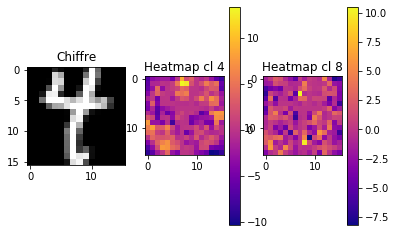

In [241]:
# trouver un échantillon mal classé (PAS DE CODE A AJOUTER):

index = np.where(Y != Y_pred)[0][0] # parmi les points d'apprentissage
print(index)

plt.figure()
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow((X-1)[index].reshape(16,16),cmap="gray")
plt.title("Chiffre")
plt.subplot(1,3,2)
plt.imshow((((X-1)[index]-1)*Wm[:,int(Y[index])]).reshape(16,16),cmap="plasma")
plt.colorbar()
plt.title("Heatmap cl "+str(int(Y[index])))
plt.subplot(1,3,3)
plt.imshow((((X-1)[index]-1)*Wm[:,int(Y_pred[index])]).reshape(16,16),cmap="plasma")
plt.title("Heatmap cl "+str(int(Y_pred[index])))
plt.colorbar()

## Exercice 6: Régularisation, performance & interprétation

Dans ce problème en assez grande dimension (256), nous voyons un peu de sur-apprentissage: les performances sont meilleures en apprentissage qu'en test.

On fait souvent l'hypothèse que ce phénomène est lié à un estimateur trop complexe. Afin de simplifier la fonction de coût, on proposer de régulariser le problème d'apprentissage qui devient:

$$\arg\max_\theta  \mathcal L - \lambda \Omega(\theta), \qquad \mbox{avec: } \Omega(\theta) = \left\{\begin{array}{cl}
\sum_j \theta_j^2 & \mbox{ régularisation } L_2 \\
\sum_j |\theta_j| & \mbox{ régularisation } L_1 \\
\end{array}
\right.$$

$\lambda$ doit être choisi soigneusement sous peine d'aboutir à une solution dégénée (ou non modifiée). La régularisation $L_2$ est plus stable est facile à exploiter, la régularisation $L_1$ est plus complexe et moins stable mais elle permet d'annuler complètement les poids attribués à certains pixels. En effet, dans l'implémentation, nous allons traiter la fonction $\Omega$ à part de la vraisemblance:
Toutes les itérations, nous allons mettre à jour:

$$\mathbf w \leftarrow \mathbf w - \lambda \left\{\begin{array}{cl}
\nabla_{\mathbf w,b} \Omega(\mathbf w,b) = 2\mathbf w, 2b  & \mbox{ régularisation } L_2 \\
\nabla_{\mathbf w,b} \Omega(\mathbf w,b) = sign(\mathbf w),sign(b) & \mbox{ régularisation } L_1 \\
\end{array}
\right. $$

En interprétant la formule ci-dessus, on se rend compte que ça ramène systématiquement les poids du modèle vers 0: l'idée est donc bien de simplifier le modèle... Seuls les dimensions vraiment intéressantes seront pondérées.

**Note:** Par défaut, il n'est pas évident d'améliorer les performances avec la régularisation sur ce problème... C'est néanmoins une procédure très efficace sur la plupart des jeux de données.

**Note2:** Les expériences étant un peu chères en temps de calcul, pensez à réduire niter_max pendant le debug

In [262]:
def rl_gradient_batch_reg(X,Y, epsilon = 1e-3, niter_max=1000, lam=1e-5):
    N,d = X.shape
    w = np.zeros(d)
    #w = np.random.randn(d)
    b = np.ones(N)
    
    for i in range(niter_max):
        pred = 1 / (1 + np.exp(-(np.dot(X,w)+b)))
        wNew= w + epsilon *np.dot(X.T , (Y - pred)) 
        wNew = wNew - lam * 2*wNew
        wNew = wNew - lam * np.sign(wNew)
        b = b + epsilon * (Y - pred)
        b = b - lam * 2*b
        b = b - lam * np.sign(b)
        if np.abs(wNew - w).max() < 1e-3:
            print("convergence atteinte en  {}  itérations".format(i))
            return w,b
        w = wNew
    
    print("convergence atteinte en  {}  itérations".format(i))
    return w,b

# Soit vous passez des fonctions en arguments, soit il faut redéfinir une nouvelle version de rl_multi
# dans le cadre du TP, on prend la seconde option: plus simple mais plus moche
def rl_multi_reg(X,Y, epsilon = 1e-3, niter_max=1000, lam=1e-5):
    N,d = X.shape
    classes = np.unique(Y)
    # Initialiser les poids & lancer un modèle par classe
    # dans la boucle for, vous pouvez utiliser : Y_tmp = np.where(Y == c, 1., 0.)
    W = []
    B = []
    for c in classes:
        Y_tmp = np.where(Y == c, 1., 0.)
        w , b = rl_gradient_batch_reg(X,Y_tmp,epsilon,niter_max)
        W.append(w)
        B.append(b)
    return np.asarray(W).T, np.asarray(B).T

In [258]:
Wreg,Breg = rl_multi(X,Y)

C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations
convergence atteinte en  999  itérations


In [259]:
# Evaluation des performances
# TODO
# perf:

Y_pred  = np.argmax(1/(1+np.exp(-X@Wreg - Breg)),1)
Yt_pred = np.argmax(1/(1+np.exp(-Xt@Wreg -Breg[Xt.shape[0],:])),1)


pc_good   = np.where(Y_pred == Y , 1., 0.).mean()
pc_good_t = np.where(Yt_pred==Yt , 1., 0.).mean()

print("App : ",pc_good)
print("Test : ",pc_good_t)

App :  0.8843780002743108
Test :  0.8310911808669657


## Exercice 6: Malédiction de la dimensionnalité

Nous vous proposons ici de modifier les données pour ajouter des colonnes de bruit. Montrer que la performances se réduit lorsque l'on augmente le nombre de dimensions fantomes.

- la fonction d'ajout des données fantomes est fournie
- faites la boucle avec des ajouts de $[0,100,150,200,250]$ colonnes et tracer l'évolution des performances en apprentissage et en test.
    - Attention: il faut donc modifier $X$ et $Xt$ avec le même nombre de colonne fantome
    
**Note:** les expériences sont couteuses, encore une fois, limitez niter_max ou faites les calculs sur un serveur distant (3 minutes en limitant à 300 itérations)... <BR>
Attention, le fait de limiter les itérations est une forme de régularisation (appelée *early stopping*): s'il n'y a pas assez d'itération, on ne voit pas les effets pervers de la dimensionnalité des données!

**Note 2:** Evidemment, c'est dans ce cas de figure -qui correspond à beaucoup d'applications réelles- que la régularisation va aider.

Avec 300 itérations, vous obtenez:
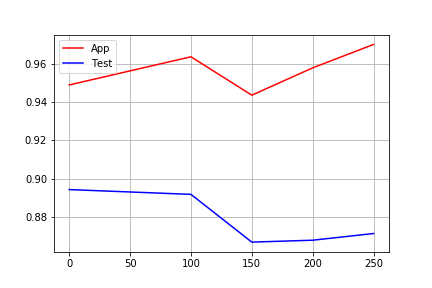

In [260]:
# On ajoute du bruit (et on enlève 1) 
# ATTENTION : ne pas enlever une seconde fois 1 ensuite !
def ajout_colonne_randn(X,d, sig = 1.):
    return np.hstack((X-1, np.random.randn(len(X),d)*sig))

In [274]:
dnoise    = np.array([0,100,150,200,250])
perf_app  = np.zeros(len(dnoise))
perf_test = np.zeros(len(dnoise))

for i,d in enumerate(dnoise):
    tempX = ajout_colonne_randn(X,d)
    tempXt = ajout_colonne_randn(Xt,d)
    
    W,B = rl_multi_reg(tempX,Y,niter_max=300)
    
    
    Y_pred  = np.argmax(1/(1+np.exp(-tempX@W - B)),1)
    Yt_pred = np.argmax(1/(1+np.exp(-tempXt@W -B[tempXt.shape[0],:])),1)


    perf_app[i]   = np.where(Y_pred == Y , 1., 0.).mean()
    perf_test[i]  = np.where(Yt_pred==Yt , 1., 0.).mean()

convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atteinte en  299  itérations
convergence atte

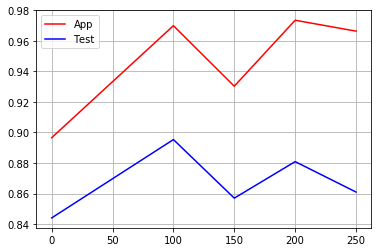

In [275]:
plt.figure()
plt.plot(dnoise,perf_app, 'r')
plt.plot(dnoise,perf_test, 'b')
plt.legend(['App','Test'])
plt.grid()
plt.savefig('CurseDim.png')

## Exercice 7: et par rapport aux méthodes discriminantes à base de fonctions de cout?

Tester l'algorithme du perceptron vu en cours, avec l'astuce du un-contre-tous pour le passage au multi-classes.
Attention, pour le perceptron, le codage des deux classes est en $\{-1, 1\}$